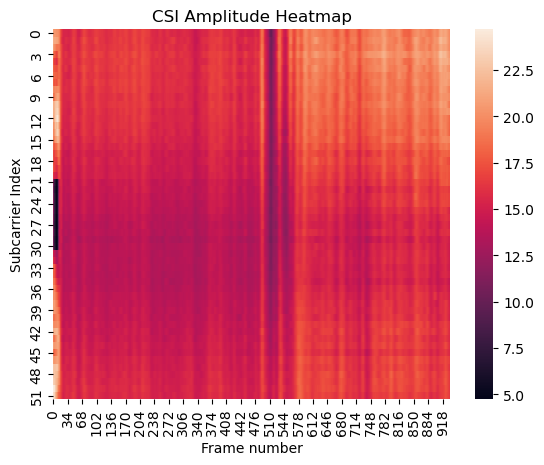

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from CSIKit.filters.passband import lowpass
from CSIKit.filters.statistical import running_mean
from CSIKit.util.filters import hampel

def get_csi_data_from_csv(filename):
  df = pd.read_csv(filename)
  csi_data = df['CSI_DATA']
  csi_data = csi_data.str[1:-2].str.split(' ').to_list()
  csi_data = map(lambda csi: np.array(list(map(float, csi))), csi_data)

  return np.array(list(csi_data)).T

def remove_null_subporters(csi_data):
  left_cutpoint = 6
  central_subporter_index = 32
  right_cutpoint = -5

  return np.concatenate((
    csi_data[left_cutpoint*2: central_subporter_index*2, :],
    csi_data[(central_subporter_index+1)*2: right_cutpoint*2, :],
  ))

def extract_subporters_magnitudes(csi_data):
  real_parts = csi_data[::2, :]
  imaginary_parts = csi_data[1::2, :]
  amplitudes = np.sqrt(real_parts**2 + imaginary_parts**2)

  return amplitudes

def apply_filters(csi_data):
  csi_data = np.apply_along_axis(lambda subcarrier_data: lowpass(subcarrier_data, 10, 100, 5), 1, csi_data)
  csi_data = np.apply_along_axis(lambda subcarrier_data: hampel(subcarrier_data, 10, 3), 1, csi_data)
  csi_data = np.apply_along_axis(lambda subcarrier_data: running_mean(subcarrier_data, 10), 1, csi_data)

  return csi_data

csi_data = get_csi_data_from_csv('csi_data.csv')
csi_data = remove_null_subporters(csi_data)
csi_data = extract_subporters_magnitudes(csi_data)
csi_data = apply_filters(csi_data)

ax = sns.heatmap(csi_data)
plt.title("CSI Amplitude Heatmap")
ax.set(xlabel='Frame number', ylabel='Subcarrier Index')
plt.show()

(936, 64, 1, 1)
(936, 64)


/home/paulo/anaconda3/lib/python3.10/site-packages/scipy/signal/_arraytools.py:102: RuntimeWarning: invalid value encountered in subtract
  2 * right_end - right_ext),


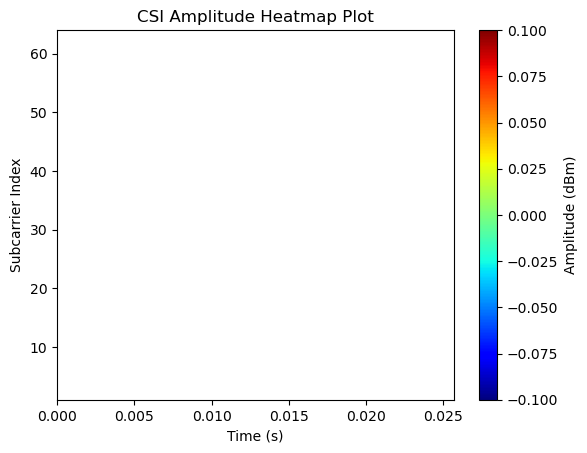

In [25]:
from CSIKit.filters.passband import lowpass
from CSIKit.filters.statistical import running_mean
from CSIKit.util.filters import hampel

from CSIKit.reader import get_reader
from CSIKit.tools.batch_graph import BatchGraph
from CSIKit.util import csitools

import numpy as np

my_reader = get_reader("csi_data.csv")
csi_data = my_reader.read_file("csi_data.csv", scaled=True)
csi_matrix, no_frames, no_subcarriers = csitools.get_CSI(csi_data, metric="amplitude")

# CSI matrix is now returned as (no_frames, no_subcarriers, no_rx_ant, no_tx_ant).
# First we'll select the first Rx/Tx antenna pairing.
csi_matrix_first = csi_matrix[:, :, 0, 0]
# Then we'll squeeze it to remove the singleton dimensions.
csi_matrix_squeezed = np.squeeze(csi_matrix_first)

# This example assumes CSI data is sampled at ~100Hz.
# In this example, we apply (sequentially):
#  - a lowpass filter to isolate frequencies below 10Hz (order = 5)
#  - a hampel filter to reduce high frequency noise (window size = 10, significance = 3)
#  - a running mean filter for smoothing (window size = 10)

for x in range(no_frames):
  csi_matrix_squeezed[x] = lowpass(csi_matrix_squeezed[x], 10, 100, 5)
  csi_matrix_squeezed[x] = hampel(csi_matrix_squeezed[x], 10, 3)
  csi_matrix_squeezed[x] = running_mean(csi_matrix_squeezed[x], 10)

BatchGraph.plot_heatmap(csi_matrix_squeezed, csi_data.timestamps)